In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder
# %cd /content/drive/MyDrive/CellCount

In [ ]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

In [1]:
import os
import torch
import datetime
from model import *
from utils import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

# ignore

In [ ]:
%pylab inline
import torchvision.transforms as T
from torch.nn import ConstantPad2d
import numpy as np

def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(10, 10))
    fig = plt.figure(figsize=(100, 100))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def five_crop():
    root_dir = "./Train"
    fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
    img_path = "./cropped_train/Images/"
    label_path = "./cropped_train/Labels/"
    for idx in range(len(fileNames)):
        size = 500
        img_name = os.path.join(root_dir,"Images", fileNames[idx])+".png"
        mask_name = os.path.join(root_dir,"Labels", fileNames[idx])+".mat"
        dictmat = loadmat(mask_name)
        orig_img = Image.open(img_name)
        (top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(size, size))(orig_img)
        cropped = [top_left, top_right, bottom_left, bottom_right, center]
        
        orig_img.save(img_path + fileNames[idx] + "_original.png")
        savemat(label_path + fileNames[idx] + "_original.mat", {"inst_map": dictmat["inst_map"]})    
        for img_idx in range(len(cropped)):
            name = ""
            labels = {}
            if img_idx == 0:
                name = "top_left"
                labels["inst_map"] = dictmat["inst_map"][0:size, 0:size]
            elif img_idx == 1:
                name = "top_right"
                labels["inst_map"] = dictmat["inst_map"][0:size, 1000-size:1000]
            elif img_idx == 2:
                name = "bottom_left"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 0:size]
            elif img_idx == 3:
                name = "bottom_right"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 1000-size:1000]
            elif img_idx == 4:
                name = "center"
                mid_height = 1000/2
                mid_weight = 1000/2
                labels["inst_map"] = dictmat["inst_map"][round(mid_height-size/2):round(mid_height+size/2), round(mid_weight-size/2):round(mid_weight+size/2)]
            
            ## pad images and labels
            cropped[img_idx] = T.Pad(padding=250, fill=(0,0,0), padding_mode='constant')(cropped[img_idx])
            labels["inst_map"] = np.pad(labels["inst_map"], 1, pad_with, padder=0)
            ## save 
            cropped[img_idx].save(img_path + fileNames[idx] + "_" +name+".png")            
            savemat(label_path + fileNames[idx] + "_" +name+".mat", labels)           
        plot(cropped, orig_img)
#         if idx == 0:        
#             break
    
five_crop()

In [ ]:
before = "./Train/Labels/train_1.mat"
after = "./cropped_train/Labels/train_1_original.mat"

dictmat_before = loadmat(before)
dictmat_after = loadmat(after)
print(dictmat_before["inst_map"] == dictmat_after["inst_map"])

a = np.arange(6)
a = a.reshape((2, 3))
print(a)
pad = np.pad(a, 2, pad_with, padder=100)
print(pad)

# Start here

In [2]:
class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),3)
        if self.transform:
            image = self.transform(image)

        return image, mask

In [3]:
transform = transforms.Compose([
    transforms.Pad(3),
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="./Train/train_250", transform = transform)
test_data = CellDataset(root_dir="./Test/test_250", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=0)

# load validation data in batches
valid_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=valid_sampler,
                          num_workers=0)

# load test data in batches
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        num_workers=0)

## Training

In [4]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss


def dice_metric(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    union = targ.sum() + pred.sum()
    

    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    # print(intersection / union, dice)
    
    return dice


def train(model, device, train_loader, valid_loader, optimizer, epochs, patience, img_size):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    valid_acc = 0
    
    os.makedirs("best_model_checkpoints", exist_ok=True)
    os.makedirs("model_checkpoints", exist_ok=True)
    save_path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        score = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
            # Find accuracy
        
        """
        Validate the model on validation data
        """
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            pred = output.to('cpu').detach().numpy()[0][0]
            threshold=0.95
            pred[pred >= threshold] = 1
            pred[pred < threshold] = 0
            score+=get_dice_1(target, pred)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        score /= len(valid_loader)
        if score > valid_acc:
            valid_acc = score

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), f"model_checkpoints/{model.__class__.__name__}_{img_size}_{epoch}.pth")
        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

    return  model, avg_train_losses, avg_valid_losses, valid_acc

In [5]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device, "resnet")
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [6]:
print("Training")
# Training the model
epochs = 60
lr = 0.001
patience = 10  # how long to wait after last time validation loss improved
optimizer = Adam(model.parameters(), lr=lr)
img_size = "ResNet-250x250"

model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, img_size)

  0%|          | 0/60 [00:00<?, ?it/s]

Training
Validation loss decreased (inf --> 0.340872).  Saving model ...


  2%|▏         | 1/60 [00:50<49:29, 50.33s/it]

Train Epoch: 1 @ 18:50:37.994497 - Train Loss: 0.4046 - Valid Loss: 0.3409
Validation loss decreased (0.340872 --> 0.317110).  Saving model ...


  3%|▎         | 2/60 [01:39<48:21, 50.03s/it]

Train Epoch: 2 @ 18:51:27.300589 - Train Loss: 0.3262 - Valid Loss: 0.3171
Validation loss decreased (0.317110 --> 0.292613).  Saving model ...


  5%|▌         | 3/60 [02:29<47:28, 49.97s/it]

Train Epoch: 3 @ 18:52:17.129122 - Train Loss: 0.3010 - Valid Loss: 0.2926
EarlyStopping counter: 1 out of 10


  7%|▋         | 4/60 [03:18<46:28, 49.80s/it]

Train Epoch: 4 @ 18:53:06.532800 - Train Loss: 0.2876 - Valid Loss: 0.3402
EarlyStopping counter: 2 out of 10


  8%|▊         | 5/60 [04:07<45:22, 49.50s/it]

Train Epoch: 5 @ 18:53:55.336654 - Train Loss: 0.2686 - Valid Loss: 0.2964
EarlyStopping counter: 3 out of 10


 10%|█         | 6/60 [04:56<44:24, 49.34s/it]

Train Epoch: 6 @ 18:54:44.302978 - Train Loss: 0.2731 - Valid Loss: 0.3536
EarlyStopping counter: 4 out of 10


 12%|█▏        | 7/60 [05:45<43:30, 49.26s/it]

Train Epoch: 7 @ 18:55:33.385731 - Train Loss: 0.2951 - Valid Loss: 0.3046
Validation loss decreased (0.292613 --> 0.291071).  Saving model ...


 13%|█▎        | 8/60 [06:34<42:35, 49.14s/it]

Train Epoch: 8 @ 18:56:22.249776 - Train Loss: 0.2522 - Valid Loss: 0.2911
Validation loss decreased (0.291071 --> 0.264897).  Saving model ...


 15%|█▌        | 9/60 [07:23<41:47, 49.17s/it]

Train Epoch: 9 @ 18:57:11.480659 - Train Loss: 0.2397 - Valid Loss: 0.2649
EarlyStopping counter: 1 out of 10


 17%|█▋        | 10/60 [08:12<40:52, 49.05s/it]

Train Epoch: 10 @ 18:58:00.267998 - Train Loss: 0.2609 - Valid Loss: 0.6425
EarlyStopping counter: 2 out of 10


 18%|█▊        | 11/60 [09:01<40:00, 48.98s/it]

Train Epoch: 11 @ 18:58:49.087151 - Train Loss: 0.2644 - Valid Loss: 0.3190
EarlyStopping counter: 3 out of 10


 20%|██        | 12/60 [09:50<39:11, 48.99s/it]

Train Epoch: 12 @ 18:59:38.086716 - Train Loss: 0.2755 - Valid Loss: 0.2855
EarlyStopping counter: 4 out of 10


 22%|██▏       | 13/60 [10:39<38:21, 48.97s/it]

Train Epoch: 13 @ 19:00:27.017612 - Train Loss: 0.2441 - Valid Loss: 0.2765
EarlyStopping counter: 5 out of 10


 23%|██▎       | 14/60 [11:28<37:32, 48.97s/it]

Train Epoch: 14 @ 19:01:15.981053 - Train Loss: 0.2288 - Valid Loss: 0.2729
EarlyStopping counter: 6 out of 10


 25%|██▌       | 15/60 [12:17<36:45, 49.01s/it]

Train Epoch: 15 @ 19:02:05.083318 - Train Loss: 0.2732 - Valid Loss: 0.2856
EarlyStopping counter: 7 out of 10


 27%|██▋       | 16/60 [13:06<35:55, 48.99s/it]

Train Epoch: 16 @ 19:02:54.015507 - Train Loss: 0.2560 - Valid Loss: 0.2989
EarlyStopping counter: 8 out of 10


 28%|██▊       | 17/60 [13:55<35:05, 48.98s/it]

Train Epoch: 17 @ 19:03:42.969729 - Train Loss: 0.2691 - Valid Loss: 0.2891
EarlyStopping counter: 9 out of 10


 30%|███       | 18/60 [14:43<34:13, 48.88s/it]

Train Epoch: 18 @ 19:04:31.630381 - Train Loss: 0.2369 - Valid Loss: 0.3318


 30%|███       | 18/60 [15:32<36:16, 51.82s/it]

EarlyStopping counter: 10 out of 10
Early stopping


In [7]:
print("DICE score:", valid_acc)

DICE score: 0.7330125839247092


# Graphs

In [8]:
def plot_graph(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, 0.5) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

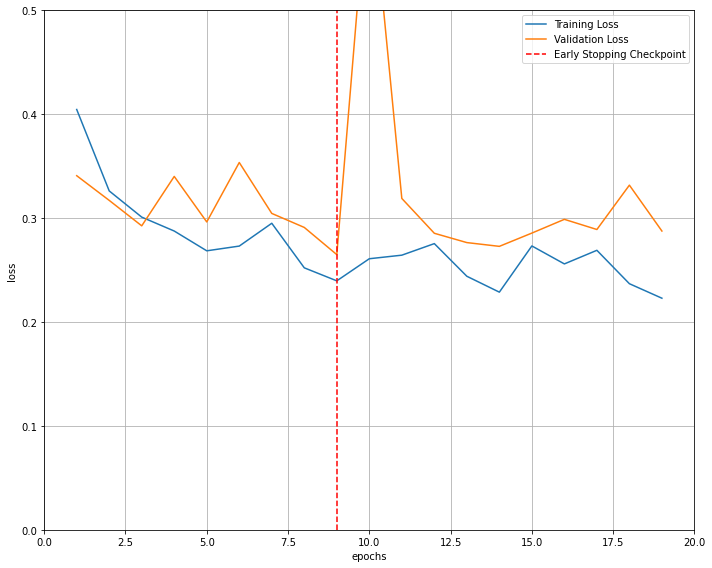

In [9]:
plot_graph(train_loss, valid_loss)

# Load model


In [ ]:
# load saved model
def load_model(model):
  path = f"model_checkpoints/{model.__class__.__name__}.pt"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model
model = load_model(model)

# Test

In [ ]:
def test(model, device, data, target):
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))
    pred = outputs.to('cpu').detach().numpy()[0][0]

    print("Predicted Mask Sigmoid")
    plt.imshow(pred,cmap='gray')
    plt.show()
    threshold=0.95
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    print("Predicted Mask Binary")
    plt.imshow(pred,cmap='gray')
    plt.show()
    print("Actual Mask")
    plt.imshow(target[0],cmap='gray')
    plt.show()

    # iou
    iou_score = iou(target, pred)
    print("iou score:", iou_score)

    # AJI
    aji_score = get_fast_aji(target, pred)
    print("AJI score:", aji_score)

    # AJI+
    aji_plus_score = get_fast_aji_plus(target, pred)
    print("AJI+ score:", aji_plus_score)

    # PQ
    pq_score = get_fast_pq(target, pred)[0]
    print("Detection Quality (DQ):", pq_score[0])
    print("Segmentation Quality (SQ):", pq_score[1])
    print("Panoptic Quality (PQ):", pq_score[2])

    # Dice2
    dice2_score = get_fast_dice_2(target, pred)
    print("Dice2 score:", dice2_score, "\n")
    
    dice_score = get_dice_1(target, pred)
    print("Dice score:", dice_score, "\n")

    return iou_score, aji_score, aji_plus_score, pq_score, dice2_score

In [ ]:
# Testing the model
for data, target in test_loader:
    iou_score, aji_score, aji_plus_score, pq_score, dice2_score = test(model, device, data, target)
    break